In [20]:
import os

import contextily as ctx
import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
output_path = "./assets/Spatiotemporal Coverage/"
def save_plot(filename):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(
        f"{output_path}/{filename}.png",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{output_path}/{filename}.pdf",
        bbox_inches="tight",
    )

In [21]:
def get_company_color(company):
    if company == 6:
        return sns.color_palette("Set2")[company - 1 % len(sns.color_palette("Set2"))]
    return sns.color_palette("Set1")[company - 1 % len(sns.color_palette("Set1"))]

In [35]:
def plot_spatiotemporal_coverage(df, category):
    # Criar GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326"
    )
    gdf = gdf.to_crs(
        epsg=3857
    )  # Projeção para mapas da Web (compatível com contextily)

    # Obtém os limites do GeoDataFrame (em EPSG:3857)
    bbox = gdf.total_bounds  # [minx, miny, maxx, maxy]

    # Calcula a margem (5% do tamanho em cada eixo)
    margin_x = (bbox[2] - bbox[0]) * 0.05
    margin_y = (bbox[3] - bbox[1]) * 0.05

    # Aplica a margem aos limites
    minx = bbox[0] - margin_x
    maxx = bbox[2] + margin_x
    miny = bbox[1] - margin_y
    maxy = bbox[3] + margin_y

    # Adjusting subplot dimensions and stretching images
    fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(16, 12), dpi=300)
    axes = axes.flatten()

    unique_t = df["t"].unique()
    # Selecionar 24 valores únicos de 't' com espaçamento uniforme
    selected_t = unique_t[np.linspace(0, len(unique_t) - 1, 24, dtype=int)]

    for i, st in enumerate(selected_t):
        ax = axes[i]

        # Filtrar por hora
        gdf_s = gdf[gdf["t"] == st]

        if not gdf_s.empty:
            if category is not None:
                for company in gdf_s[category].unique():
                    gdf_s_c = gdf_s[gdf_s[category] == company]
                    # Adiciona a cor da empresa
                    color = get_company_color(company)
                    gdf_s_c.plot(
                        ax=ax,
                        color=color,
                        markersize=5,
                    )
            else:
                gdf_s.plot(ax=ax, color="red", markersize=5)

        # Ajustar mapa
        ax.set_title(
            st.strftime("%H:%M:%S"), fontsize=24, backgroundcolor="#cccccc"
        )
        ax.axis("off")
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.set_aspect("auto")  # Stretch images to fill subplot space

        # Adicionar background
        try:
            ctx.add_basemap(
                ax,
                crs=gdf_s.crs.to_string(),
                source=ctx.providers.CartoDB.Positron,
                attribution_size=2,
            )
        except (ValueError, KeyError, TypeError):
            pass  # caso não haja pontos nessa hora

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    handles, labels = axes[-1].get_legend_handles_labels()
    # Custom legend for Company colors
    if category == "Company":
        categorias = df[category].unique()
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=get_company_color(c), markersize=10, label=f'Company {c}')
            for c in categorias
        ]
        fig.legend(handles=legend_elements, loc='lower center', fontsize=24, ncol=3, bbox_to_anchor=(0.5, -0.1))
    else:
        fig.legend(handles, labels, loc='lower center', fontsize=24, ncol=6, bbox_to_anchor=(0.5, -0.05))
    # Verifica se a pasta de saída existe, se não, cria
    save_plot(category)
    plt.show()

In [32]:
cud_okabe_ito_colors = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # reddish orange
    "#CC79A7",  # purple
    "#000000",  # black
]

In [33]:
enriched_points = dd.read_csv(
    "./anglova_metrics_enriched/points_enriched_metrics.csv",
).compute()
enriched_points["t"] = pd.to_datetime(enriched_points["t"])
enriched_trajectories_df = pd.read_csv(
    "./anglova_metrics_enriched/trajectories_enriched_metrics.csv",
)

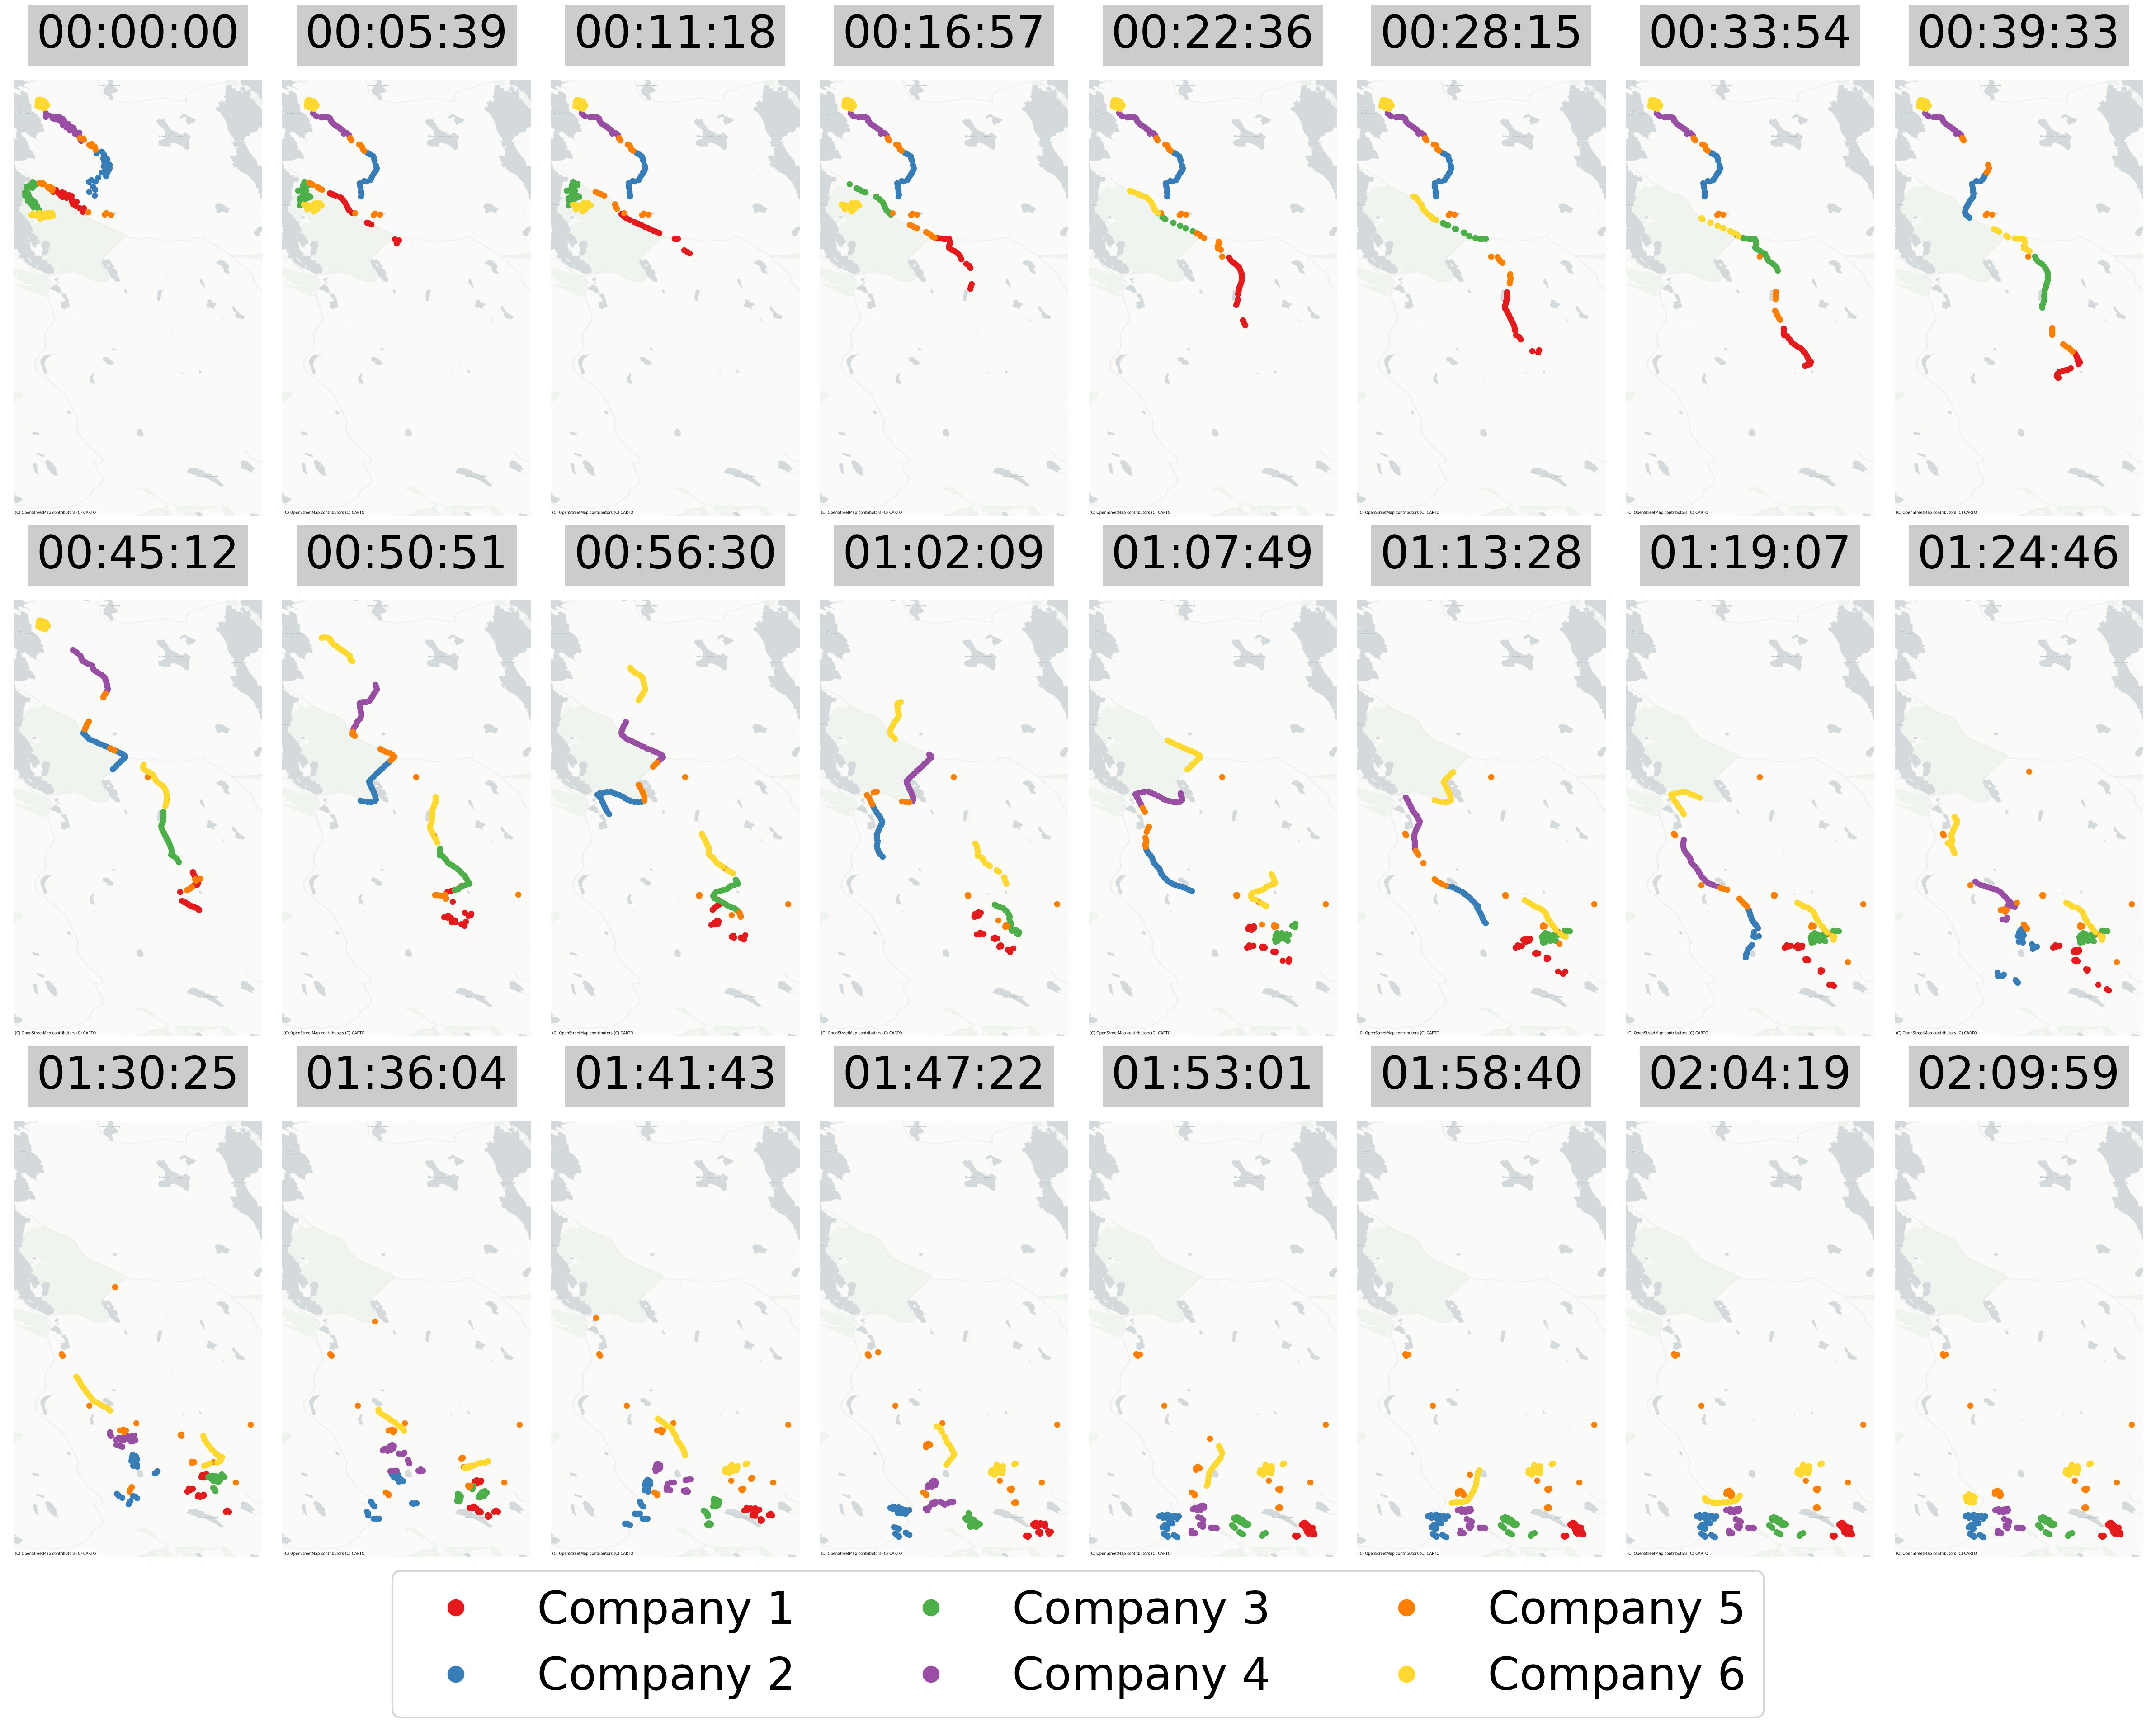

In [36]:
categorias = [
    # None,
    "Company",
    # "Company Type",
    # "Platoon",
    # "Platoon Type",
    # "Vehicle Function",
    # "Vehicle Type",
    # "Command",
]
for cat in categorias:
    plot_spatiotemporal_coverage(
        enriched_points,
        category=cat,
    )